In [1]:
import sys
import cuentitas
from entornomaximo import entornoMaximo as em
from auxiliares import integracionGauss as ig
from auxiliares import medicion
from auxiliares import sigma
from auxiliares import sigmaEmi
from auxiliares import S0VV_completo

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
import random

import pymc3 as pm

sns.set() #seaborn como default

m = 51 #valores que siempre uso
X,Y,Wt = ig(m-1)

In [2]:
def generador(n): #me devuelve array de 2*n, n angulos entre 10 y 30 y n sigma0
    angulos = []
    for i in range(n):
        angulos.append(random.uniform(10,30))
    
    res = []
    for j in range(len(angulos)):
        res.append(sigma(1.93,3,0.05,0.0017,0.015,0.001,0.015,angulos[j]))

    return np.asarray([np.asarray(angulos), np.asarray(res)])

In [3]:
def generadorEmisividad(n): #me devuelve 2d array con n angulos (entre 10 y 30) y 2n con n sigma0 y n emisividades
    angulos = []
    for i in range(n):
        angulos.append(random.uniform(10,30))
    
    s0 = []
    emi = []
    for j in range(len(angulos)):
        s0.append(sigmaEmi(1.93,3,0.05,0.0017,0.015,0.001,0.015,angulos[j],X,Y,Wt,m)[0])
        emi.append(sigmaEmi(1.93,3,0.05,0.0017,0.015,0.001,0.015,angulos[j],X,Y,Wt,m)[1])
    
    out = s0+emi
    return np.asarray([np.asarray(angulos), np.asarray(out)])

In [25]:
def toFitE(ep1,ep2,d,s1,l1,s2,l2,angulo):
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
    
    ### emi
    thi = 0.0001*np.pi/180
    
    ths_ = (X+1)*np.pi/4
    phs_ = (Y+1)*np.pi
    
    ths_1 = np.reshape(ths_, (1,m**2))
    phs_1 = np.reshape(phs_, (1,m**2))
    
    q = (np.sin(ths_1)*S0VV_completo(k0,thi,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
    aux = Wt*q
    I_gauss = (np.pi**2/4)*aux.sum()
 
    emi = 1 - (I_gauss/(4*np.pi))

    a = TT.zeros(4)
    aa = TT.set_subtensor(a[0], s0s[0])
    aaa = TT.set_subtensor(aa[1], s0s[1])
    aaaa = TT.set_subtensor(aaa[2], s0s[2])
    aaaaa = TT.set_subtensor(aaaa[3], emi)
 
    return aaaaa

In [26]:
def toFit(ep1,ep2,d,s1,l1,s2,l2,angulo):
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
    
    nn = len(angulo)
    
    a = TT.zeros(nn)
    print(s0s, type(s0s))
    for i in range(nn):
        a = TT.set_subtensor(a[i], s0s[i])
        
#    aa = TT.set_subtensor(a[0], s0s[0])
#    aaa = TT.set_subtensor(aa[1], s0s[1])
#    aaaa = TT.set_subtensor(aaa[2], s0s[2])
    
    
 
    return a

In [127]:
def toFitEmis(ep1,ep2,d,s1,l1,s2,l2,anguloWR,anguloR): #Me devuelve un tensor de nn+mm, con nn valores de angulos s0 y mm emis
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    
    ### s0
    phs = phi + np.pi
    thi = anguloR  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)

    ### Emisividad
    thiEm = anguloWR*np.pi/180

    ths_ = (X+1)*np.pi/4
    phs_ = (Y+1)*np.pi
    
    ths_1 = np.reshape(ths_, (1,m**2))
    phs_1 = np.reshape(phs_, (1,m**2))
    
    emi = []
    for tt in thiEm:
        q = (np.sin(ths_1)*S0VV_completo(k0,tt,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
        aux = Wt*q
        I_gauss = (np.pi**2/4)*aux.sum()
 
        emi.append(1 - (I_gauss/(4*np.pi)))
    
    nn = len(anguloR)
    mm = len(anguloWR)
    pp = nn+mm
#     emi = np.asarray(emi)
#     print(emi)
#     aux2 = np.zeros(pp)
#     print(aux2, type(aux2))
#     aux2[nn:] = np.asarray(emi)
#     print(aux2)
    
    a = TT.zeros(pp)
    for i in range(nn):
        a = TT.set_subtensor(a[i], s0s[i])
    
    for j in range(mm):
        a = TT.set_subtensor(a[nn+j], emi[j])
    
    return a
 
    
#    out = np.concatenate((s0s,emi),axis=None)
#     print(s0s, type(s0s))
#     print(emi, type(emi))
#     print(out, type(out))
#    a = TT.zeros(5)
#     aa = TT.set_subtensor(a[0], s0s[0])
#     aaa = TT.set_subtensor(aa[1], s0s[1])
#     aaaa = TT.set_subtensor(aaa[2], s0s[2])
#     aaaaa = TT.set_subtensor(aaaa[3], emi[0])
#     aaaaaa = TT.set_subtensor(aaaaa[4], emi[1])
 
#     return aaaaaa

#     a = TT.zeros(pp)

#     for i in range(pp):
#         if i < nn:
#             a = TT.set_subtensor(a[i], s0s[i])
#         else:
#             a = TT.set_subtensor(a[i],aux2[i])
    
#     return a

#     d = {}
#     for x in range(len(out)):
#         d["{0}".format(x)] = TT.set_subtensor(a[x], out[x])
    
#     return d[str(len(out)-1)]

In [128]:
traza = modelo([np.asarray([10,15,20]),np.asarray([-4,-6,-8,0.98,0.99])],np.asarray([15,20]),muestras,noiseSTD**2)

Sample initial stage: ...
Stage:   0 Beta: 0.031 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.216 Steps:  25 Acce: 0.616
Stage:   2 Beta: 1.000 Steps:   4 Acce: 1.000


In [119]:
d = toFitEmis(1.9,3,0.05,0.0017,0.015,0.001,0.015,np.asarray([15,20]),np.asarray([10,15,20]))
#toFita(1.9,3,0.05,0.0017,0.015,0.001,0.015,np.asarray([10,15,20]))
#toFit(1.9,3,0.05,0.0017,0.015,0.001,0.015,np.asarray([10,15,20]))

[0.98840531 0.99051626]
[0.         0.         0.         0.98840531 0.99051626]


In [117]:
def S0VV(k0,thi,phi,th,phs,ep1,ep2,d,s1,l1,s2,l2):
    
    k1 = k0*(sin(th)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(th)*sin(phs)-sin(thi)*sin(phi))
    
    return 4*np.pi*k0**2*cos(th)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,th,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,th,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,th,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,th,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))

In [142]:
pppp = toFitEmis(1.9,3,0.05,0.0017,0.015,0.001,0.015,np.asarray([10,15]),np.asarray([11,16,18,21]))
ths_ = (X+1)*np.pi/4
phs_ = (Y+1)*np.pi
phs_1 = np.reshape(phs_, (1,m**2))
ths_1 = np.reshape(ths_, (1,m**2))
thi = np.asarray([10,15,3])*np.pi/180
phi = np.pi
ko = 2*np.pi/0.025
print(len((sin(ths_1)*sin(phs_1))[0]))
S0VV(ko,10,phi,ths_1,phs_1,1.9,3,0.05,0.0017,0.015,0.001,0.015)
print(pppp)

2601
[array([ -5.16114296,  -7.90361276,  -9.31044375, -11.73371799]), array([0.986955  , 0.98840531])]


In [7]:
def modelo(sector, angWR, samples, sigmas): #angWR es el angulo sin ruido
 
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi

    
    ranges = {}
    ranges['ep1'] = 1.4, 8
    ranges['s1'] = 0.0004, 0.004
 
    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])

#    def f(ep1 = ep1, 
#          s1 = s1):
#        return toFit(ep1,3,0.05,s1,0.015,0.001,0.015,sector[0])

    def f(ep1 = ep1, 
          s1 = s1):
        return toFitEmis(ep1,3,0.05,s1,0.015,0.001,0.015,angWR,sector[0])


#    print('angulos usados: ', sector[0])
    
    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1])
        trace = pm.sample_smc(samples)  
    
    return trace

In [86]:
#n = 11
#[angGen, valGen] = generador(n)
#print(angGen)
#print(valGen)
#valRui = valGen + 0.1*np.random.randn(-1,1,len(valGen))
#print(valRui)

In [129]:
[ang,se] = generadorEmisividad(2)
val = se[:len(ang)]
emi = se[len(ang):]

val = np.reshape(val,(len(val),1))
n = 2
snrDB = 20 
snr = 10**(snrDB/10) #escala lineal

psignal = np.mean(val**2) #potencia promedio (db)

noiseSTD =  np.sqrt(psignal/snr)

valRui = np.kron(val,np.ones((n,1))) + noiseSTD*np.random.randn(n*len(val),1)

angR = np.reshape(ang,(len(ang),1))
angR = np.kron(angR,np.ones((n,1)))

angR = np.reshape(angR, (len(angR)))
valR = np.reshape(valRui, (len(valRui)))

emi = np.reshape(emi,(len(emi),1))
emiRui = emi + 0.001*np.random.randn(len(emi),1)
emiR = np.reshape(emiRui,(len(emi)))

seR = np.concatenate((valR,emiR))

C:\Users\arell\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [131]:
print(ang)
print(angR)
print(seR)

[16.33807928 13.90978803]
[16.33807928 16.33807928 13.90978803 13.90978803]
[-7.72375625 -8.9455081  -5.53485123 -5.79609888  0.99014881  0.98645846]


In [132]:
m = 51
X,Y,Wt = ig(m-1)

zonaMed = 'HU2'
muestras = 5

#sigmas = np.asarray([0.1, 0.1, 0.1])
#traza = modelo(medicion(zonaMed),muestras,sigmas)

#traza = modelo([np.asarray([10,15,20]),np.asarray([-4.639,-7.02,-10.49])],muestras,0.1)
#traza = modelo([angR,valRui],muestras,noiseSTD**2)
traza = modelo([angR,seR],ang,muestras,noiseSTD**2)

Sample initial stage: ...
Stage:   0 Beta: 0.003 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.007 Steps:  25 Acce: 0.680
Stage:   2 Beta: 0.069 Steps:   4 Acce: 0.550
Stage:   3 Beta: 0.552 Steps:   5 Acce: 0.960
Stage:   4 Beta: 0.914 Steps:   2 Acce: 0.400
Stage:   5 Beta: 1.000 Steps:   9 Acce: 0.844


In [77]:
e1 = traza['ep1']
s1 = traza['s1']

guardar = [e1,s1]

#f = np.savetxt('ruidoCN5.txt', guardar, delimiter=';')
#f2 = np.savetxt('ruidoCN5-input.txt', [angGen,valGen,valRui], delimiter=';')
print('Archivo guardado')


Archivo guardado


Ploteando...


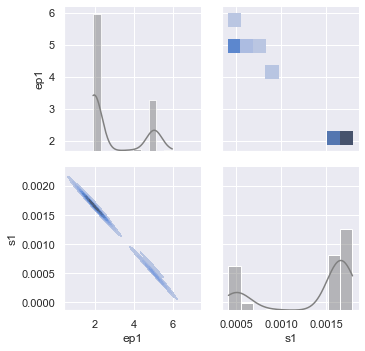

In [97]:
#Ploteo
print('Ploteando...')

plotear = np.stack((traza['ep1'], traza['s1'])).T
dfplotear = pd.DataFrame(plotear, columns = ['ep1','s1'])

g = sns.PairGrid(dfplotear)
#g.fig.suptitle('N=5 - ruidoC', y=1.01, fontsize = 'large')
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
#g.savefig('N=5-ruidoC.png')


angulos usados:  [18.1843607  22.20214164 14.21800687 15.17977144 11.88540326 25.23310393
 27.64136873 24.11749301 23.51809719 13.15579077]


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:  25 Acce: 0.474
Stage:   2 Beta: 0.003 Steps:   7 Acce: 0.273
Stage:   3 Beta: 0.008 Steps:  14 Acce: 0.132
Stage:   4 Beta: 0.027 Steps:  25 Acce: 0.058
Stage:   5 Beta: 0.081 Steps:  25 Acce: 0.024
Stage:   6 Beta: 0.241 Steps:  25 Acce: 0.012
Stage:   7 Beta: 0.718 Steps:  25 Acce: 0.006
Stage:   8 Beta: 1.000 Steps:  25 Acce: 0.005


Archivo guardado
Ploteando...
angulos usados:  [18.1843607  22.20214164 14.21800687 15.17977144 11.88540326 25.23310393
 27.64136873 24.11749301 23.51809719]


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:  25 Acce: 0.472
Stage:   2 Beta: 0.003 Steps:   7 Acce: 0.278
Stage:   3 Beta: 0.009 Steps:  14 Acce: 0.135
Stage:   4 Beta: 0.028 Steps:  25 Acce: 0.061
Stage:   5 Beta: 0.085 Steps:  25 Acce: 0.026
Stage:   6 Beta: 0.252 Steps:  25 Acce: 0.012
Stage:   7 Beta: 0.720 Steps:  25 Acce: 0.006
Stage:   8 Beta: 1.000 Steps:  25 Acce: 0.005


Archivo guardado
Ploteando...
angulos usados:  [18.1843607  22.20214164 14.21800687 15.17977144 11.88540326 25.23310393
 27.64136873 24.11749301]


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:  25 Acce: 0.469
Stage:   2 Beta: 0.003 Steps:   7 Acce: 0.279
Stage:   3 Beta: 0.010 Steps:  14 Acce: 0.136
Stage:   4 Beta: 0.031 Steps:  25 Acce: 0.058
Stage:   5 Beta: 0.098 Steps:  25 Acce: 0.026
Stage:   6 Beta: 0.288 Steps:  25 Acce: 0.012
Stage:   7 Beta: 0.792 Steps:  25 Acce: 0.007
Stage:   8 Beta: 1.000 Steps:  25 Acce: 0.006


Archivo guardado
Ploteando...
angulos usados:  [18.1843607  22.20214164 14.21800687 15.17977144 11.88540326 25.23310393
 27.64136873]


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:  25 Acce: 0.469
Stage:   2 Beta: 0.004 Steps:   7 Acce: 0.275
Stage:   3 Beta: 0.011 Steps:  14 Acce: 0.127
Stage:   4 Beta: 0.036 Steps:  25 Acce: 0.057
Stage:   5 Beta: 0.111 Steps:  25 Acce: 0.025
Stage:   6 Beta: 0.321 Steps:  25 Acce: 0.013
Stage:   7 Beta: 0.866 Steps:  25 Acce: 0.007
Stage:   8 Beta: 1.000 Steps:  25 Acce: 0.007


Archivo guardado
Ploteando...
angulos usados:  [18.1843607  22.20214164 14.21800687 15.17977144 11.88540326 25.23310393]


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:  25 Acce: 0.461
Stage:   2 Beta: 0.005 Steps:   7 Acce: 0.263
Stage:   3 Beta: 0.017 Steps:  15 Acce: 0.126
Stage:   4 Beta: 0.055 Steps:  25 Acce: 0.059
Stage:   5 Beta: 0.165 Steps:  25 Acce: 0.026
Stage:   6 Beta: 0.511 Steps:  25 Acce: 0.012
Stage:   7 Beta: 1.000 Steps:  25 Acce: 0.006


Archivo guardado
Ploteando...
angulos usados:  [18.1843607  22.20214164 14.21800687 15.17977144 11.88540326]


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:  25 Acce: 0.460
Stage:   2 Beta: 0.007 Steps:   7 Acce: 0.258
Stage:   3 Beta: 0.029 Steps:  15 Acce: 0.122
Stage:   4 Beta: 0.095 Steps:  25 Acce: 0.058
Stage:   5 Beta: 0.302 Steps:  25 Acce: 0.026
Stage:   6 Beta: 0.909 Steps:  25 Acce: 0.012
Stage:   7 Beta: 1.000 Steps:  25 Acce: 0.006


Archivo guardado
Ploteando...
angulos usados:  [18.1843607  22.20214164 14.21800687 15.17977144]


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.001 Steps:  25 Acce: 0.463
Stage:   2 Beta: 0.008 Steps:   7 Acce: 0.268
Stage:   3 Beta: 0.035 Steps:  14 Acce: 0.129
Stage:   4 Beta: 0.113 Steps:  25 Acce: 0.059
Stage:   5 Beta: 0.364 Steps:  25 Acce: 0.027
Stage:   6 Beta: 1.000 Steps:  25 Acce: 0.012


Archivo guardado
Ploteando...
angulos usados:  [18.1843607  22.20214164 14.21800687]


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.002 Steps:  25 Acce: 0.465
Stage:   2 Beta: 0.012 Steps:   7 Acce: 0.247
Stage:   3 Beta: 0.047 Steps:  16 Acce: 0.121
Stage:   4 Beta: 0.153 Steps:  25 Acce: 0.056
Stage:   5 Beta: 0.489 Steps:  25 Acce: 0.025
Stage:   6 Beta: 1.000 Steps:  25 Acce: 0.012


Archivo guardado
Ploteando...
angulos usados:  [18.1843607  22.20214164]


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.003 Steps:  25 Acce: 0.475
Stage:   2 Beta: 0.018 Steps:   7 Acce: 0.261
Stage:   3 Beta: 0.084 Steps:  15 Acce: 0.125
Stage:   4 Beta: 0.270 Steps:  25 Acce: 0.055
Stage:   5 Beta: 0.881 Steps:  25 Acce: 0.026
Stage:   6 Beta: 1.000 Steps:  25 Acce: 0.012


Archivo guardado
Ploteando...
angulos usados:  [18.1843607]


Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.005 Steps:  25 Acce: 0.464
Stage:   2 Beta: 0.039 Steps:   7 Acce: 0.262
Stage:   3 Beta: 0.292 Steps:  15 Acce: 0.126
Stage:   4 Beta: 1.000 Steps:  25 Acce: 0.054


Archivo guardado
Ploteando...


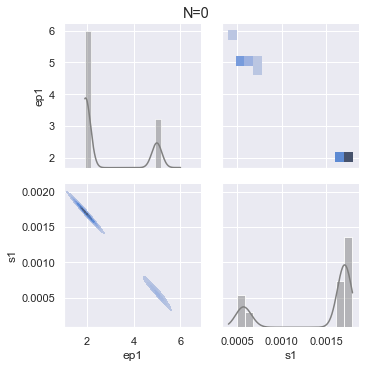

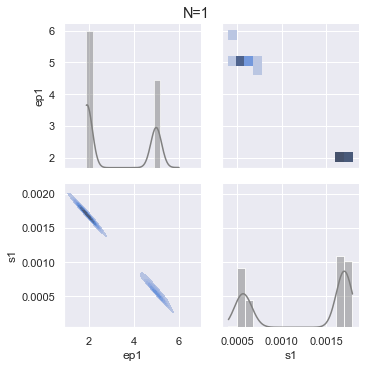

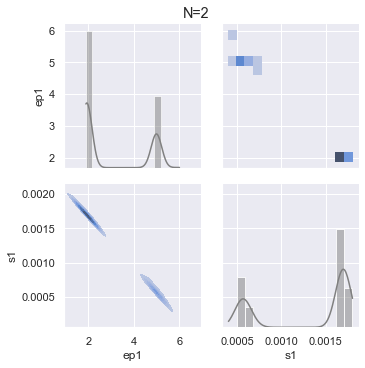

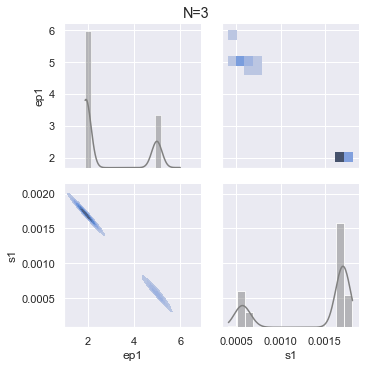

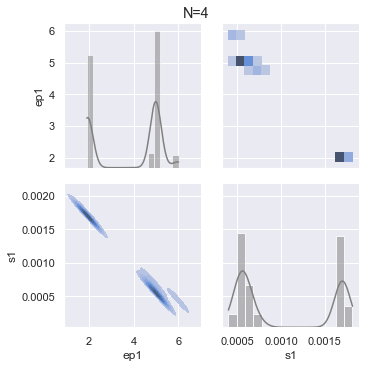

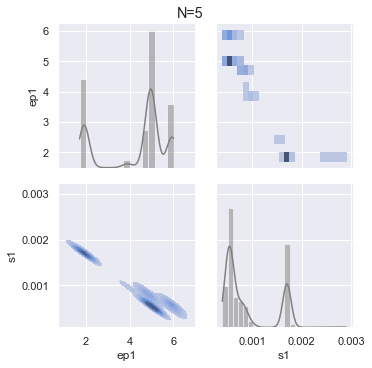

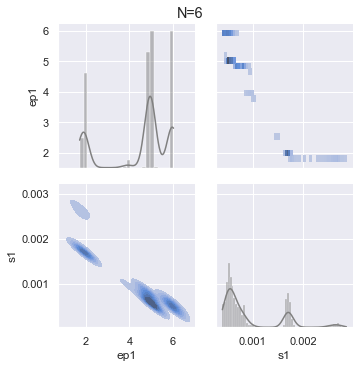

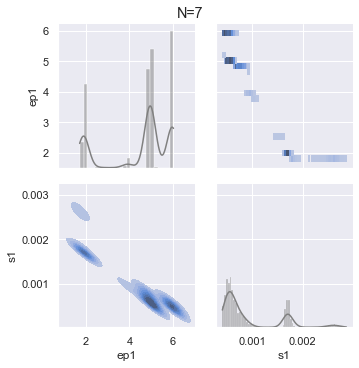

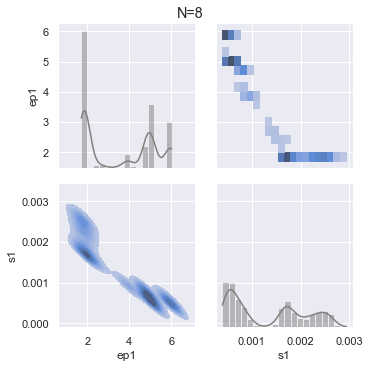

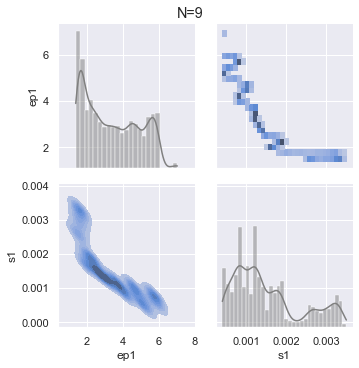

In [30]:
 #genera con cantidades de 1 a 10
    
#[angGen, valGen] = generador(11)


for i in range(len(angGen)-1): 
    
    traza = modelo([angGen[:-i-1],valGen[:-i-1]],10000,0.1)

    e1 = traza['ep1']
    s1 = traza['s1']
    guardar = [e1,s1]

    f = np.savetxt('Sigma/N'+str(i)+'.txt', guardar, delimiter=';')
    f2 = np.savetxt('Sigma/N'+str(i)+'-input.txt', [angGen,valGen], delimiter=';')
    print('Archivo guardado')

    #Ploteo
    print('Ploteando...')

    plotear = np.stack((traza['ep1'], traza['s1'])).T
    dfplotear = pd.DataFrame(plotear, columns = ['ep1','s1'])

    g = sns.PairGrid(dfplotear)
    g.fig.suptitle('N='+str(i), y=1.01, fontsize = 'large')
    g.map_upper(sns.histplot)
    g.map_lower(sns.kdeplot, fill=True)
    g.map_diag(sns.histplot, kde=True, color='.5')
    g.savefig('Sigma/N'+str(i)+'.png')


NameError: name 'e1' is not defined

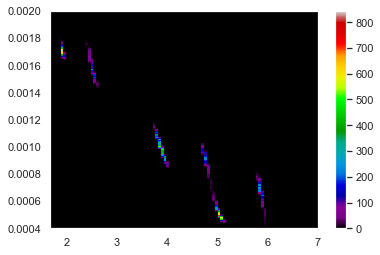

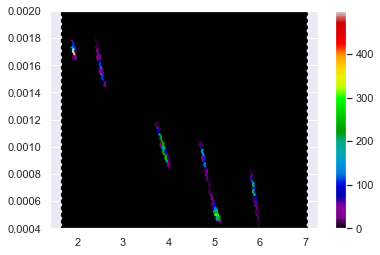

In [99]:
xx = pru[0]
yy = pru[1]
x_bins = np.linspace(np.min(xx), np.max(xx), 100)
y_bins = np.linspace(np.min(yy), np.max(yy), 500)
plt.hist2d(xx,yy,bins=[x_bins,y_bins],cmap = plt.cm.nipy_spectral)
plt.colorbar()
plt.ylim(0.0004,0.002)
plt.figure()
plt.hexbin(xx,yy,bins=500,cmap = plt.cm.nipy_spectral)
plt.colorbar()
plt.ylim(0.0004,0.002)


---------
Prueba sobre cada maximo

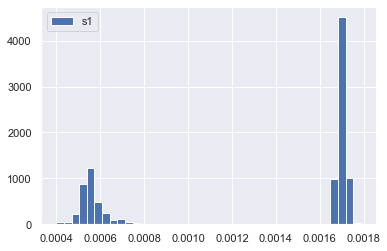

In [35]:
y, x, _ = plt.hist(traza['s1'],bins=40, label='s1')
plt.legend()

In [ ]:
S0VV_Fran_completo(2*np.pi/0.025,15,np.pi,15,2*np.pi,ep1,ep2,0.05,0.0017,0.015,0.001,0.015)

In [91]:
def plotear(ep1,ep2):
    return 10*np.log10(S0VV_Fran_completo(2*np.pi/0.025,27.15*np.pi/180,np.pi,27.15*np.pi/180,2*np.pi,ep1,ep2,0.05,0.0017,0.015,0.001,0.015))
def plotear2(ep1,ep2):
    return 10*np.log10(S0VV_Fran_completo(2*np.pi/0.025,27.15*np.pi/180,np.pi,27.15*np.pi/180,2*np.pi,ep1,ep2,0.05,0.0005,0.015,0.001,0.015))

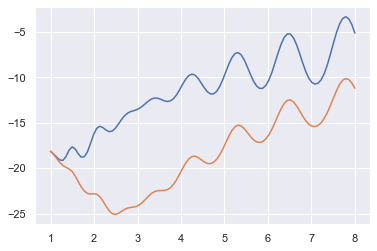

In [93]:
epsilon1 = np.linspace(1,8,100)
epsilon2 = np.linspace(1,8,100)

plt.plot(epsilon1, plotear(epsilon1,3))
plt.plot(epsilon2, plotear2(epsilon1,3))
plt.plot

In [53]:
#Genero los valores del modelo para estos angulos incidentes
angPrueba = [10,15,20]

for i in angPrueba:
    print('thi = ',i,': ',prueba(1.93,3,0.05,0.0017,0.015,0.001,0.015,i))

#esto es lo que devuelve
back = [-4.639,-7.020,-10.492]

thi =  10 :  (-4.639658114654706, 0.9854867397806576)
thi =  15 :  (-7.020294116808399, 0.9854867397806576)
thi =  20 :  (-10.492452448846416, 0.9854867397806576)


In [7]:
def prueba(ep1,ep2,d,s1,l1,s2,l2,angulo): #funcion de antes pero sin la parte tensorial
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
    
    ### emi
    X,Y,Wt = ig(50)
    
    thi = 0.0001*np.pi/180
    
    ths_ = (X+1)*np.pi/4
    phs_ = (Y+1)*np.pi
    
    ths_1 = np.reshape(ths_, (1,m**2))
    phs_1 = np.reshape(phs_, (1,m**2))
    
    q = (np.sin(ths_1)*S0VV_Fran_completo(k0,thi,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
    aux = Wt*q
    I_gauss = (np.pi**2/4)*aux.sum()
 
    emi = 1 - (I_gauss/(4*np.pi))

    return s0s, emi

In [17]:
print(prueba(4.9,3,0.05,0.0005,0.015,0.001,0.015,1.818436070339912192e+01))
print(prueba(1.9,3,0.05,0.0017,0.015,0.001,0.015,1.818436070339912192e+01))

(-10.779656399752298, 0.9878926451211318)
(-9.448830435966933, 0.9858996818621227)


In [12]:
m = 51

In [98]:
pru = np.loadtxt('prueba-e1s1.txt', delimiter=';') #output del sampler


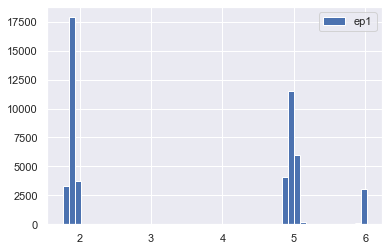

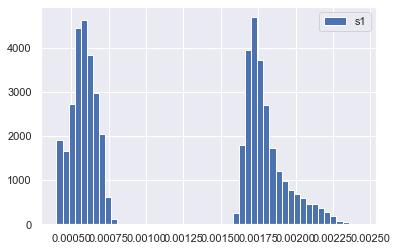

In [10]:
y, x, _ = plt.hist(pru[0],bins=50, label='ep1')
plt.legend()
plt.figure()
y2, x2, _2 = plt.hist(pru[1],bins=50, label='s1')
plt.legend()
y2 = np.asarray(y2)
x2 = np.asarray(x2)

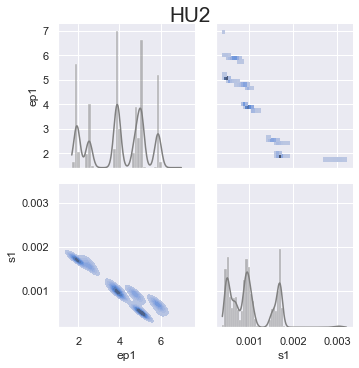

In [41]:
plotear = np.stack((pru[0], pru[1])).T#, traza['d'], traza['s1'], traza['l1'], traza['s2'], traza['l2'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1','s1'])#,'d','s1','l1','s2','l2'])

g = sns.PairGrid(dfplotear)
g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')

In [57]:
ee = [x[16],x[25],x[1],x[31],x[6],x[23]]
ss = [x2[0],x2[17],x2[6],x2[7]] #Anote cuales son los indices en mi libretita
print(ss)
print(ee)
auxx1 = []
#auxx2 = []
#auxx3 = []
for e in range(len(ee)):
    for s in range(len(ss)):
        print('\n eps1 = ', ee[e],' - s1 = ',ss[s])
        print(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,10))
        print(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,15))
        print(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,20))
        auxx1.append(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,10))
        auxx2.append(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,15))
        auxx3.append(prueba(ee[e],3,0.05,ss[s],0.015,0.001,0.015,20))

[0.0004003661684850914, 0.0015933870327917662, 0.0008214323558874472, 0.0008916100537878398]
[3.8103828506473536, 5.010116979069004, 1.8108259699446037, 5.809939731350104, 2.4773449301788535, 4.7435093949753036]

 eps1 =  3.8103828506473536  - s1 =  0.0004003661684850914
(-11.68975125587416, 0.996605331381465)
(-14.131996961065491, 0.996605331381465)
(-17.41114349391433, 0.996605331381465)

 eps1 =  3.8103828506473536  - s1 =  0.0015933870327917662
(-1.568720644678945, 0.9658951697526235)
(-4.008483984991635, 0.9658951697526235)
(-7.266854220634632, 0.9658951697526235)

 eps1 =  3.8103828506473536  - s1 =  0.0008214323558874472
(-6.907396236715274, 0.9899631209595513)
(-9.347806265855676, 0.9899631209595513)
(-12.611578292297608, 0.9899631209595513)

 eps1 =  3.8103828506473536  - s1 =  0.0008916100537878398
(-6.277875294667168, 0.9884109845093717)
(-8.718161977041898, 0.9884109845093717)
(-11.9809031073586, 0.9884109845093717)

 eps1 =  5.010116979069004  - s1 =  0.0004003661684850914

In [65]:
indices = [2,3,4,9,12,14,15,17,22,23]

auxx1 = np.asarray(auxx1)
auxx2 = np.asarray(auxx2)
auxx3 = np.asarray(auxx3)
buenos1 = []
buenos2 = []
buenos3 = []
for i in indices:
    buenos1.append(auxx1[i,:])
    buenos2.append(auxx2[i,:])
    buenos3.append(auxx3[i,:])

buenos1 = np.asarray(buenos1)
buenos2 = np.asarray(buenos2)
buenos3 = np.asarray(buenos3)

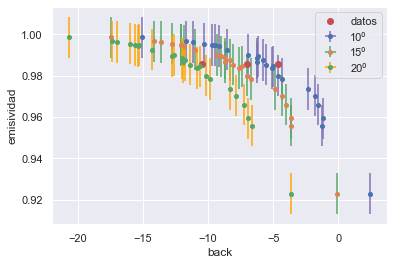

In [30]:
plt.errorbar(auxx1[:,0],auxx1[:,1],yerr=0.01,xerr=0.1,ecolor='m',fmt='o',label='10º',ms=4)
plt.errorbar(auxx2[:,0],auxx2[:,1],yerr=0.01,xerr=0.1,ecolor='g',fmt='o', label ='15º',ms=4)
plt.errorbar(auxx3[:,0],auxx3[:,1],yerr=0.01,xerr=0.1,ecolor='orange',fmt='o', label ='20º',ms=4)
plt.plot([-4.639658114654706,-7.020294116808399,-10.492452448846416],[0.9854867397806576,0.9854867397806576,0.9854867397806576],'or',label='datos')
plt.xlabel('back')
plt.ylabel('emisividad')
plt.legend()

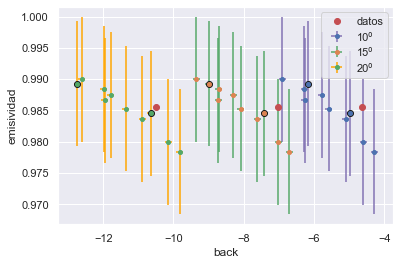

In [69]:
plt.errorbar(buenos1[:,0],buenos1[:,1],yerr=0.01,xerr=0.1,ecolor='m',fmt='o',label='10º',ms=4)
plt.errorbar(buenos2[:,0],buenos2[:,1],yerr=0.01,xerr=0.1,ecolor='g',fmt='o', label ='15º',ms=4)
plt.errorbar(buenos3[:,0],buenos3[:,1],yerr=0.01,xerr=0.1,ecolor='orange',fmt='o', label ='20º',ms=4)
plt.plot([-4.639658114654706,-7.020294116808399,-10.492452448846416],[0.9854867397806576,0.9854867397806576,0.9854867397806576],'or',label='datos')
plt.plot([-6.178722362318685,-8.989390749875275,-12.744122092631088], [0.9892394723818398, 0.9892394723818398, 0.9892394723818398],'ok')
plt.plot([-4.981289712474401,-7.415926189879119,-10.64156325184218],[0.9845078255757418, 0.9845078255757418, 0.9845078255757418],'ok')

plt.xlabel('back')
plt.ylabel('emisividad')
plt.legend()

----------